In [678]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Cтандартная библиотека Python для работы с регулярными выражениями
import re

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Импортируем модуль stats из библиотеки scipy
from scipy import stats

#Импортируем класс LabelEncoder из модуля preprocessing из библиотики scikit-learn (sklearn)
from sklearn.preprocessing import LabelEncoder
#Импортируем класс RobustScaler из модуля sklearn.preprocessing
from sklearn.preprocessing import RobustScaler

#Импортируем модуль category_encoders под псевдонимом ce
import category_encoders as ce

# Импортируем модуль TextBlob из библиотеки textblob
from textblob import TextBlob

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [679]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [680]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [681]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [682]:
# Установим опцию для отображения максимального количества столбцов
pd.set_option('display.max_columns', None)

# Установим опцию для отображения максимального количества символов в строке
pd.set_option('display.max_colwidth', 30)

In [683]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [684]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair We...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Coupl...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Ca...,299,1/12/2017,8.3,Mercure London Bloomsbury ...,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Coup...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th ...,32,10/18/2016,8.9,Legend Saint Germain by El...,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo ...",289 day,48.845377,2.325643


In [685]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [686]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Mil...,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a ...,52,16670,Hotel was great clean fri...,62,1,"[' Leisure trip ', ' Coupl...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 10...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was p...,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 0800...,46,11/26/2015,8.3,Alexandra Barcelona A Doub...,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo...",616 day,41.393192,2.161520


In [687]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [688]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [689]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [690]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Mil...,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a ...,52,16670,Hotel was great clean fri...,62,1,"[' Leisure trip ', ' Coupl...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 10...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was p...,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 0800...,46,11/26/2015,8.3,Alexandra Barcelona A Doub...,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo...",616 day,41.393192,2.161520,0,0.0


### Данная версия датасета содержит 18 полей со следующей информацией:

* *hotel_address* — адрес отеля;
* *review_date* — дата, когда рецензент разместил соответствующий отзыв;
* *average_score* — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* *hotel_name* — название отеля;
* *reviewer_nationality* — страна рецензента;
* *negative_review* — отрицательный отзыв, который рецензент дал отелю;
* *review_total_negative_word_counts* — общее количество слов в отрицательном отзыв;
* *positive_review* — положительный отзыв, который рецензент дал отелю;
* *review_total_positive_word_counts* — общее количество слов в положительном отзыве;
* *reviewer_score* — оценка, которую рецензент поставил отелю на основе своего опыта;
* *total_number_of_reviews_reviewer_has_given* — количество отзывов, которые рецензенты дали в прошлом;
* *total_number_of_reviews* — общее количество действительных отзывов об отеле;
* *tags* — теги, которые рецензент дал отелю;
* *days_since_review* — количество дней между датой проверки и датой очистки;
* *additional_number_of_scoring* — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* *lat* — географическая широта отеля;
* *lng* — географическая долгота отеля;



In [691]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### Визуализации данных

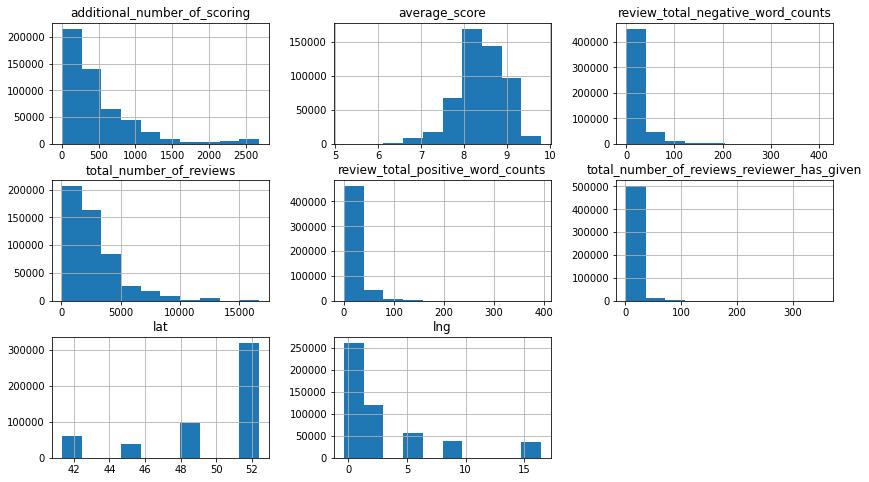

In [692]:
# Гистограмма для числовых признаков 
num_features = data.drop(columns=['sample', 'reviewer_score'], axis=1).hist(figsize=(14, 8))
num_features;


По гистограммам видно, что данные признаки не являются нормальными, проверим с помощью тест Шапиро-Уилка:

In [693]:
# Список признаков для проведения теста
features = ['additional_number_of_scoring', 'average_score', 'total_number_of_reviews',
            'reviewer_score']

# Проходим по каждому признаку и проводим тест Шапиро-Уилка
for feature in features:
    statistic, p_value = stats.shapiro(data[feature])
    
    # Выводим результатов
    print(f"Feature: {feature}")
    print(f"Statistic: {statistic}")
    print(f"P-value: {p_value}")
    
    # Оценка нормальности
    alpha = 0.05  # Уровень значимости
    if p_value > alpha:
        print("Данные распределены нормально")
    else:
        print("Данные не являются нормальными")
    print("-----------------------------")

Feature: additional_number_of_scoring
Statistic: 0.7665483951568604
P-value: 0.0
Данные не являются нормальными
-----------------------------
Feature: average_score
Statistic: 0.9783191084861755
P-value: 0.0
Данные не являются нормальными
-----------------------------
Feature: total_number_of_reviews
Statistic: 0.8177287578582764
P-value: 0.0
Данные не являются нормальными
-----------------------------
Feature: reviewer_score
Statistic: 0.767931342124939
P-value: 0.0
Данные не являются нормальными
-----------------------------


---

### Обработка пропущенных значений


In [694]:
# Проверяем пропущенные значения в столбцах
missing_values = data.isnull().sum()
missing_values

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

In [695]:
# Заменяем пропущенные значения медианой для признаков 'lat' и 'lng'
data['lat'] = data['lat'].fillna(data['lat'].median())
data['lng'] = data['lng'].fillna(data['lng'].median())

In [696]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

---

### Работа с категориальными признаками

In [697]:
# Выбираем столбцы с типом данных 'object' для дальнейшей обработки
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
object_columns 

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

### Обработка признака 'hotel_address'

In [698]:
# Посчитаем количество уникальных значений в столбце 'hotel_address'
data['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

Для дальнейшей работы с признаками, было решено создать и оставить только признак "city", так как при создании признака "country" в дальнейшем появляются сильные коррелирующие связи между признаками, которые все равно требуют удаления.

In [699]:
# Функция, которая извлекает название города
def extract_city(address):
    split_address = address.split()
    city = split_address[-2]  # Получаем второй элемент с конца, который должен быть названием города
    return city

# Применим функцию extract_city к столбцу 'hotel_address'
data['city'] = data['hotel_address'].apply(extract_city)
data['city'] = data['hotel_address'].apply (lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' 
                                            else x.split()[-2])

# Выводим уникальные значения городов
data['city'].unique()


array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

In [700]:
# Посчитаем количество уникальных значений в столбце 'city'
data['city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

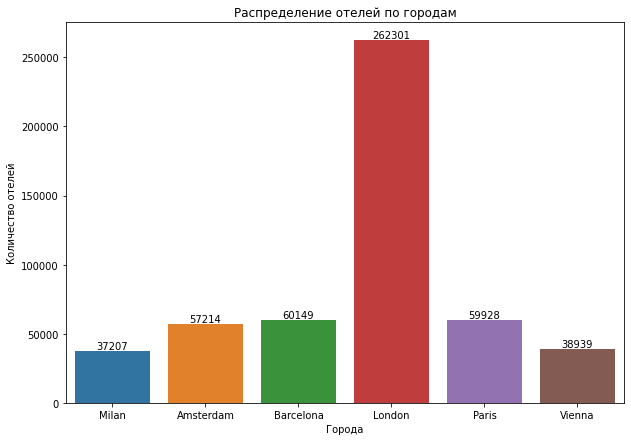

In [701]:
# Построим диаграмму по городам
fig, ax = plt.subplots(figsize=(10, 7))

barplot = sns.countplot(x='city', data=data, ax=ax)

barplot.set_title('Распределение отелей по городам')
barplot.set_xlabel('Города')
barplot.set_ylabel('Количество отелей')

for container in barplot.containers:
    ax.bar_label(container)

plt.show()


По графику видно, что большинство отелей находится в городе Лондон (Великобритания). По остальным городам количество отелей распределено относительно равно - Амстердам, Барселона, Париж. Далее количество идет на спад - Вена и Милан.

In [702]:
# Кодируем признак "city"
data = pd.get_dummies(data, columns=['city'])
data.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,city_Amsterdam,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna
0,Via Senigallia 6 20161 Mil...,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a ...,52,16670,Hotel was great clean fri...,62,1,"[' Leisure trip ', ' Coupl...",13 days,45.533137,9.171102,0,0.0,0,0,0,1,0,0
1,Arlandaweg 10 Westpoort 10...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was p...,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group...",234 day,52.385649,4.834443,0,0.0,1,0,0,0,0,0
2,Mallorca 251 Eixample 0800...,46,11/26/2015,8.3,Alexandra Barcelona A Doub...,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo...",616 day,41.393192,2.161520,0,0.0,0,1,0,0,0,0
3,Piazza Della Repubblica 17...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the ...,27,9,"[' Leisure trip ', ' Coupl...",656 day,45.479888,9.196298,0,0.0,0,0,0,1,0,0
4,Singel 303 309 Amsterdam C...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming ...,7,2,"[' Business trip ', ' Solo...",444 day,52.370545,4.888644,0,0.0,1,0,0,0,0,0


### Обработка признака 'review_date'

In [703]:
# Преобразуем в формат даты
data['review_date'] = pd.to_datetime(data['review_date'], format='%m/%d/%Y')

# Извлечем год, месяц, день
data['year'] = data['review_date'].dt.year
data['month'] = data['review_date'].dt.month
data['day'] = data['review_date'].dt.day

# Удалим исходный столбец
data = data.drop('review_date', axis=1) 


In [704]:
# Создаем новый признак 'season'
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

data['season'] = data['month'].apply(get_season)

In [705]:
#Преобразуем категориальные признаки в числовые значения с использованием порядкового кодирования
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(data[['season']])
data = pd.concat([data, data_bin], axis = 1)


In [706]:
data.head(3)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,city_Amsterdam,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna,year,month,day,season,season
0,Via Senigallia 6 20161 Mil...,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a ...,52,16670,Hotel was great clean fri...,62,1,"[' Leisure trip ', ' Coupl...",13 days,45.533137,9.171102,0,0.0,0,0,0,1,0,0,2017,7,21,лето,1
1,Arlandaweg 10 Westpoort 10...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was p...,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group...",234 day,52.385649,4.834443,0,0.0,1,0,0,0,0,0,2016,12,12,зима,2
2,Mallorca 251 Eixample 0800...,46,8.3,Alexandra Barcelona A Doub...,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo...",616 day,41.393192,2.161520,0,0.0,0,1,0,0,0,0,2015,11,26,осень,3


### Обработка признака 'hotel_name'

In [707]:
# Посчитаем количество уникальных значений в столбце 'hotel_name'
data['hotel_name'].nunique()

1492

In [708]:
# Кодируем категориальный признак 'hotel_name' в виде целочисленных меток
label_encoder = LabelEncoder()
data['hotel_label'] = label_encoder.fit_transform(data['hotel_name'])
data = data.drop('hotel_name', axis=1)
data.head()


,hotel_address,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,city_Amsterdam,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna,year,month,day,season,season,hotel_label
0,Via Senigallia 6 20161 Mil...,904,8.1,United Kingdom,Would have appreciated a ...,52,16670,Hotel was great clean fri...,62,1,"[' Leisure trip ', ' Coupl...",13 days,45.533137,9.171102,0,0.0,0,0,0,1,0,0,2017,7,21,лето,1,612
1,Arlandaweg 10 Westpoort 10...,612,8.6,Belgium,No tissue paper box was p...,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group...",234 day,52.385649,4.834443,0,0.0,1,0,0,0,0,0,2016,12,12,зима,2,1445
2,Mallorca 251 Eixample 0800...,46,8.3,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo...",616 day,41.393192,2.161520,0,0.0,0,1,0,0,0,0,2015,11,26,осень,3,33
3,Piazza Della Repubblica 17...,241,9.1,United States of America,No Negative,0,1543,Everything including the ...,27,9,"[' Leisure trip ', ' Coupl...",656 day,45.479888,9.196298,0,0.0,0,0,0,1,0,0,2015,10,17,осень,3,735
4,Singel 303 309 Amsterdam C...,834,9.1,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming ...,7,2,"[' Business trip ', ' Solo...",444 day,52.370545,4.888644,0,0.0,1,0,0,0,0,0,2016,5,16,весна,4,633


### Обработка признака 'reviewer_nationality'

In [709]:
# Посчитаем количество уникальных значений в столбце 'reviewer_nationality'
data['reviewer_nationality'].nunique()

227

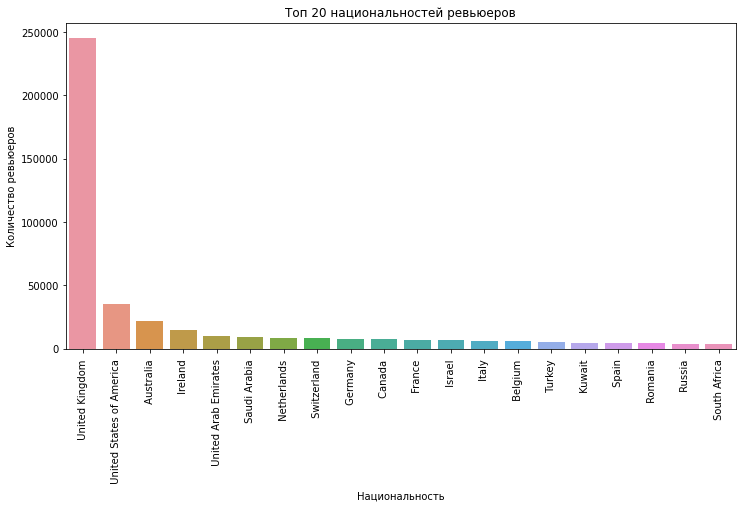

In [710]:
# Посчитаем количество ревьюеров каждой национальности ТОП-20
nationality_counts = data['reviewer_nationality'].value_counts().nlargest(20)

# Построим график
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=nationality_counts.index, y=nationality_counts.values, ax=ax)
ax.set_title('Топ 20 национальностей ревьюеров')
ax.set_xlabel('Национальность')
ax.set_ylabel('Количество ревьюеров')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show();



По графику видно, что большинство ревьюеров - граждане Англии (как и большинство отелей в Англии), на втором месте - граждане Америки, на третьем - Австралии. Потом количество по национальностям ревьюеров постепенно идет на спад.

In [711]:
# Создаем новый признак 'resident', который указывает, является ли ревьюер местным жителем
# Если национальность ревьюера присутствует в адресе отеля, то признак 'resident' равен 1, иначе равен 0
data['resident'] = data.apply(lambda x: 1 if x['reviewer_nationality'] 
                              in x['hotel_address'] else 0, axis=1)

### Обработка признаков 'days_since_review'

In [712]:
# Извлекаем числовые значения из строк
data['days_since_review'] = data['days_since_review'].str.extract('(\d+)').astype(float)

# Нормализация данных
max_days = data['days_since_review'].max()
data['days_since_review'] = data['days_since_review'] / max_days

# Проверим обработанный признак
data['days_since_review']


0         0.017808
1         0.320548
2         0.843836
3         0.898630
4         0.608219
            ...   
515733    0.145205
515734    0.234247
515735    0.743836
515736    0.101370
515737    0.497260
Name: days_since_review, Length: 515738, dtype: float64

In [713]:
data.head(5)

,hotel_address,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,city_Amsterdam,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna,year,month,day,season,season,hotel_label,resident
0,Via Senigallia 6 20161 Mil...,904,8.1,United Kingdom,Would have appreciated a ...,52,16670,Hotel was great clean fri...,62,1,"[' Leisure trip ', ' Coupl...",0.017808,45.533137,9.171102,0,0.0,0,0,0,1,0,0,2017,7,21,лето,1,612,0
1,Arlandaweg 10 Westpoort 10...,612,8.6,Belgium,No tissue paper box was p...,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group...",0.320548,52.385649,4.834443,0,0.0,1,0,0,0,0,0,2016,12,12,зима,2,1445,0
2,Mallorca 251 Eixample 0800...,46,8.3,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo...",0.843836,41.393192,2.161520,0,0.0,0,1,0,0,0,0,2015,11,26,осень,3,33,0
3,Piazza Della Repubblica 17...,241,9.1,United States of America,No Negative,0,1543,Everything including the ...,27,9,"[' Leisure trip ', ' Coupl...",0.898630,45.479888,9.196298,0,0.0,0,0,0,1,0,0,2015,10,17,осень,3,735,0
4,Singel 303 309 Amsterdam C...,834,9.1,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming ...,7,2,"[' Business trip ', ' Solo...",0.608219,52.370545,4.888644,0,0.0,1,0,0,0,0,0,2016,5,16,весна,4,633,0


### Обработка признаков 'negative_review' и 'positive_review'

In [714]:
data['negative_review']

0          Would have appreciated a ...
1          No tissue paper box was p...
2                              Pillows 
3                           No Negative
4                           No Negative
                      ...              
515733                      No Negative
515734                      No Negative
515735     room is really small but ...
515736                      No Negative
515737     Patio outside could have ...
Name: negative_review, Length: 515738, dtype: object

In [715]:
data['positive_review']

0          Hotel was great clean fri...
1                           No Positive
2            Nice welcoming and service
3          Everything including the ...
4          Lovely hotel v welcoming ...
                      ...              
515733     Tr s proche du metro Earl...
515734     The bed was so comfy I st...
515735     great location simple che...
515736      Location and very comfy bed
515737     Beds comfortable Pillows ...
Name: positive_review, Length: 515738, dtype: object

In [716]:
# Воспользуемся модулем TextBlob из библиотеки textblob для обработки и анализа текстовых данных
# Создаем функцию для анализа сентимента
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Применим функцию к столбцу с отзывами
data['negative_review_sentiments'] = data['negative_review'].apply(analyze_sentiment)
data['positive_review_sentiments'] = data['positive_review'].apply(analyze_sentiment)


In [717]:
# Создаем новые признаки на основе результата анализа сентимента
data['neg_review_sentiments'] = data['negative_review_sentiments'].apply(lambda x: 'Negative' if x < 0 else 'Neutral' if x == 0 else 'Positive')
data['pos_review_sentiments'] = data['positive_review_sentiments'].apply(lambda x: 'Negative' if x < 0 else 'Neutral' if x == 0 else 'Positive')


In [718]:
# Кодируем категориальные признаки в виде целочисленных меток
label_encoder = LabelEncoder()
data['neg_review_sentiments_encoded'] = label_encoder.fit_transform(data['neg_review_sentiments'])
data['pos_review_sentiments_encoded'] = label_encoder.fit_transform(data['pos_review_sentiments'])


In [719]:
data.head()

,hotel_address,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,city_Amsterdam,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna,year,month,day,season,season,hotel_label,resident,negative_review_sentiments,positive_review_sentiments,neg_review_sentiments,pos_review_sentiments,neg_review_sentiments_encoded,pos_review_sentiments_encoded
0,Via Senigallia 6 20161 Mil...,904,8.1,United Kingdom,Would have appreciated a ...,52,16670,Hotel was great clean fri...,62,1,"[' Leisure trip ', ' Coupl...",0.017808,45.533137,9.171102,0,0.0,0,0,0,1,0,0,2017,7,21,лето,1,612,0,-0.05,0.461364,Negative,Positive,0,2
1,Arlandaweg 10 Westpoort 10...,612,8.6,Belgium,No tissue paper box was p...,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group...",0.320548,52.385649,4.834443,0,0.0,1,0,0,0,0,0,2016,12,12,зима,2,1445,0,0.00,-0.113636,Neutral,Negative,1,0
2,Mallorca 251 Eixample 0800...,46,8.3,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo...",0.843836,41.393192,2.161520,0,0.0,0,1,0,0,0,0,2015,11,26,осень,3,33,0,0.00,0.600000,Neutral,Positive,1,2
3,Piazza Della Repubblica 17...,241,9.1,United States of America,No Negative,0,1543,Everything including the ...,27,9,"[' Leisure trip ', ' Coupl...",0.898630,45.479888,9.196298,0,0.0,0,0,0,1,0,0,2015,10,17,осень,3,735,0,0.15,0.525000,Positive,Positive,2,2
4,Singel 303 309 Amsterdam C...,834,9.1,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming ...,7,2,"[' Business trip ', ' Solo...",0.608219,52.370545,4.888644,0,0.0,1,0,0,0,0,0,2016,5,16,весна,4,633,0,0.15,0.500000,Positive,Positive,2,2


### Обработка признаков 'tags'

In [720]:
# Удалим лишние пробелы в значениях столбца 'tags'
data['tags'] = data['tags'].apply(lambda x: x.strip())

# Используем данную опцию для лучшего оторбражения признака 'tags'
#pd.set_option('display.max_colwidth', None)

# Посчитаем количество уникальных значений в столбце 'tags' и выведем ТОП-20
data['tags'].value_counts().reset_index().head(20)

,index,tags
0,"[' Leisure trip ', ' Coupl...",5101
1,"[' Leisure trip ', ' Coupl...",4931
2,"[' Leisure trip ', ' Coupl...",4366
3,"[' Leisure trip ', ' Coupl...",3991
4,"[' Leisure trip ', ' Coupl...",3291
5,"[' Leisure trip ', ' Coupl...",3102
6,"[' Leisure trip ', ' Coupl...",2947
7,"[' Leisure trip ', ' Coupl...",2906
8,"[' Leisure trip ', ' Coupl...",2620
9,"[' Leisure trip ', ' Coupl...",2362


In [721]:
# Создаем признак 'leisure_trip'
def leisure_trip(tags):
    for element in tags:
        if 'Leisure trip' in element:
            return 1
    return 0

data['leisure_trip'] = data['tags'].apply(leisure_trip)

In [722]:
# Создаем признак 'business_trip'
def business_trip(tags):
    for element in tags:
        if 'Business trip' in element:
            return 1
    return 0

data['business_trip'] = data['tags'].apply(business_trip)

In [723]:
# Воспользуемся модулем re для работы с регулярными выражениями
# Создаем признак количества ночей 'nights'
def extract_nights(tags):
    for element in tags:
        match = re.search(r'Stayed (\d+) night', element)
        if match:
            return int(match.group(1))
    return 0

data['nights'] = data['tags'].apply(extract_nights)

In [724]:
# Создаем признак 'mobile_device'
def from_mobile(tags):
    for element in tags:
        if 'Submitted from a mobile device' in element:
            return 1
    return 0

data['mobile_device'] = data['tags'].apply(from_mobile)

In [725]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [726]:
data.head()

,hotel_address,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,city_Amsterdam,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna,year,month,day,season,season,hotel_label,resident,negative_review_sentiments,positive_review_sentiments,neg_review_sentiments,pos_review_sentiments,neg_review_sentiments_encoded,pos_review_sentiments_encoded,leisure_trip,business_trip,nights,mobile_device
0,Via Senigallia 6 20161 Mil...,904,8.1,United Kingdom,Would have appreciated a ...,52,16670,Hotel was great clean fri...,62,1,"[' Leisure trip ', ' Coupl...",0.017808,45.533137,9.171102,0,0.0,0,0,0,1,0,0,2017,7,21,лето,1,612,0,-0.05,0.461364,Negative,Positive,0,2,0,0,0,0
1,Arlandaweg 10 Westpoort 10...,612,8.6,Belgium,No tissue paper box was p...,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group...",0.320548,52.385649,4.834443,0,0.0,1,0,0,0,0,0,2016,12,12,зима,2,1445,0,0.00,-0.113636,Neutral,Negative,1,0,0,0,0,0
2,Mallorca 251 Eixample 0800...,46,8.3,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo...",0.843836,41.393192,2.161520,0,0.0,0,1,0,0,0,0,2015,11,26,осень,3,33,0,0.00,0.600000,Neutral,Positive,1,2,0,0,0,0
3,Piazza Della Repubblica 17...,241,9.1,United States of America,No Negative,0,1543,Everything including the ...,27,9,"[' Leisure trip ', ' Coupl...",0.898630,45.479888,9.196298,0,0.0,0,0,0,1,0,0,2015,10,17,осень,3,735,0,0.15,0.525000,Positive,Positive,2,2,0,0,0,0
4,Singel 303 309 Amsterdam C...,834,9.1,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming ...,7,2,"[' Business trip ', ' Solo...",0.608219,52.370545,4.888644,0,0.0,1,0,0,0,0,0,2016,5,16,весна,4,633,0,0.15,0.500000,Positive,Positive,2,2,0,0,0,0


### Признак "year"

In [727]:
# Определим минимальное и максимальне значений в признаке 'year'
print(data['year'].min())
print(data['year'].max())

2015
2017


In [728]:
# Применение Ordinal Encoder к категориальному признаку 'year'
ordinal_encoder = ce.OrdinalEncoder(cols=['year'])
data = ordinal_encoder.fit_transform(data)

---

### Нормализация данных

In [729]:
# Выбираем признаки с выбросами
outlier_features = ['average_score', 'negative_review_sentiments', 'positive_review_sentiments']

# Создаем объект RobustScaler
scaler = RobustScaler()

# Применим масштабирование к выбранным признакам
data[outlier_features] = scaler.fit_transform(data[outlier_features])


### Матрица корреляции

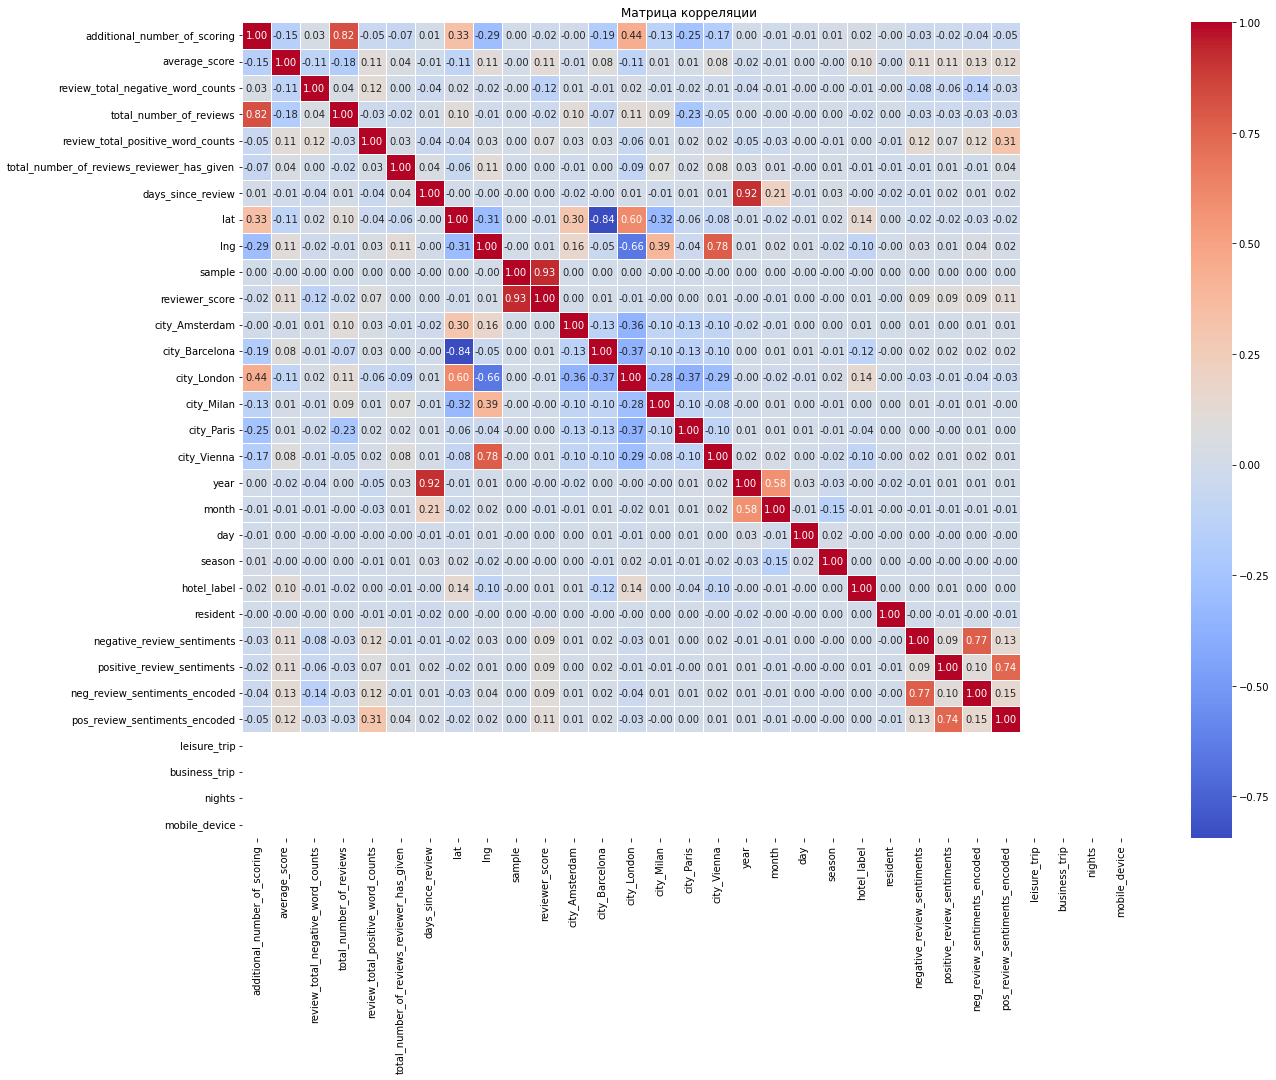

Самые сильные коррелирующие признаки:
sample                         reviewer_score                   0.931753
reviewer_score                 sample                           0.931753
year                           days_since_review                0.917266
days_since_review              year                             0.917266
lat                            city_Barcelona                   0.843640
city_Barcelona                 lat                              0.843640
total_number_of_reviews        additional_number_of_scoring     0.824884
additional_number_of_scoring   total_number_of_reviews          0.824884
lng                            city_Vienna                      0.777596
city_Vienna                    lng                              0.777596
negative_review_sentiments     neg_review_sentiments_encoded    0.771261
neg_review_sentiments_encoded  negative_review_sentiments       0.771261
pos_review_sentiments_encoded  positive_review_sentiments       0.743296
positive_revi

In [730]:
# Вычисляем матрицу корреляции
corr_matrix = data.corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

# Отбираем самые сильные коррелирующие признаки
threshold = 0.7  # Задаем пороговое значение корреляции

# Получаем значения корреляции, исключая диагональные элементы
corr_values = corr_matrix.abs().unstack().sort_values(ascending=False)
corr_values = corr_values[corr_values != 1]  #Исключаем корреляцию признака с самим собой

# Фильтруем признаки с корреляцией выше порогового значения
strong_correlations = corr_values[corr_values >= threshold]
print("Самые сильные коррелирующие признаки:")
print(strong_correlations)


In [731]:
# Удалим мультиколлинеальные признаки
data = data.drop(['days_since_review', 'lat', 'additional_number_of_scoring','lng', 
                  'neg_review_sentiments_encoded', 'pos_review_sentiments_encoded'], axis=1)


In [732]:
# Удалим все признаки с типом 'object', которые не были удалены ранее
object_columns = data.select_dtypes(include=['object']).columns
data.drop(object_columns, axis=1, inplace=True)

In [733]:
data.head()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,sample,reviewer_score,city_Amsterdam,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna,year,month,day,hotel_label,resident,negative_review_sentiments,positive_review_sentiments,leisure_trip,business_trip,nights,mobile_device
0,-0.428571,52,16670,62,1,0,0.0,0,0,0,1,0,0,1,7,21,612,0,-2.500000e-01,0.137638,0,0,0,0
1,0.285714,10,5018,0,7,0,0.0,1,0,0,0,0,0,2,12,12,1445,0,-2.775558e-16,-1.152082,0,0,0,0
2,-0.142857,3,351,5,15,0,0.0,0,1,0,0,0,0,3,11,26,33,0,-2.775558e-16,0.448598,0,0,0,0
3,1.000000,0,1543,27,9,0,0.0,0,0,0,1,0,0,3,10,17,735,0,7.500000e-01,0.280374,0,0,0,0
4,1.000000,0,4687,7,2,0,0.0,1,0,0,0,0,0,2,5,16,633,0,7.500000e-01,0.224299,0,0,0,0


<AxesSubplot:>

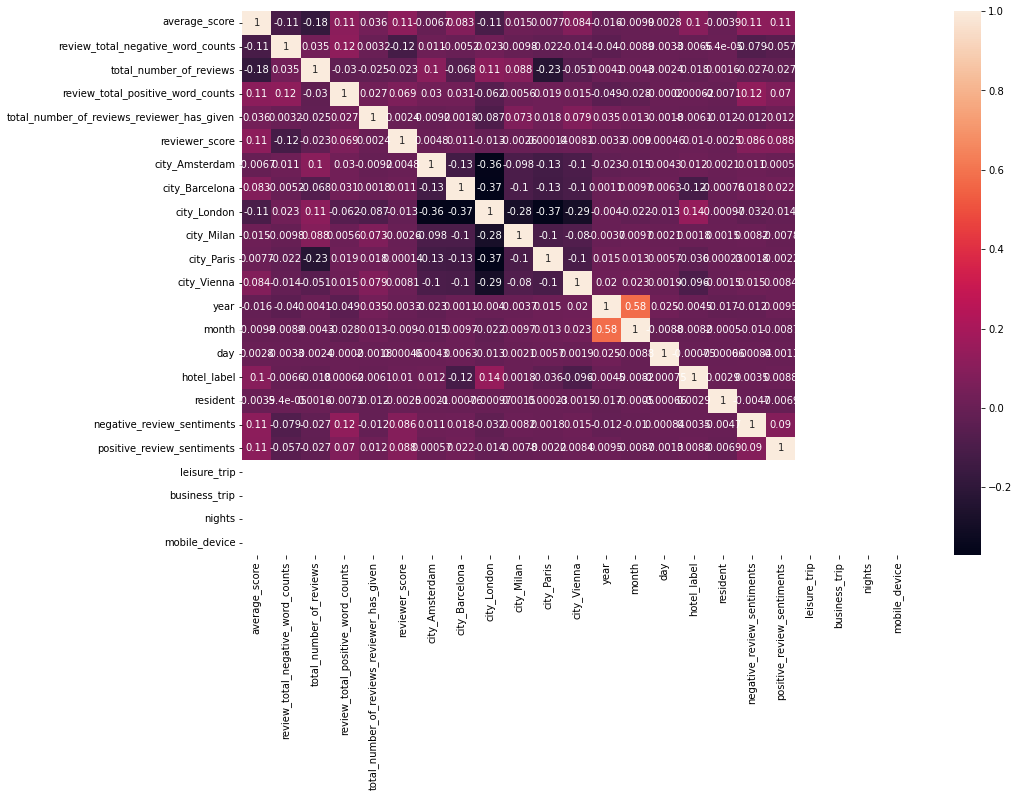

In [734]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [735]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   sample                                      515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   city_Amsterdam                              515738 non-null  uint8  
 8   city_Barcelona                              515738 non-null  uint8  
 9   city_London                                 515738 non-null  uint8  
 

In [736]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [737]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [738]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 23), (386803, 23), (386803, 22), (309442, 22), (77361, 22))

In [739]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [740]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [741]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


In [742]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
#print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAPE: 12.98913928011262


<AxesSubplot:>

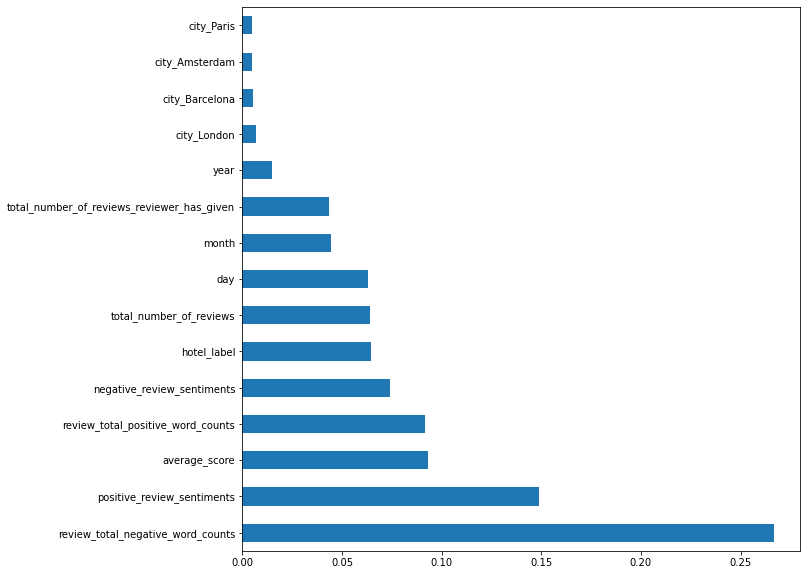

In [743]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [744]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,city_Amsterdam,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna,year,month,day,hotel_label,resident,negative_review_sentiments,positive_review_sentiments,leisure_trip,business_trip,nights,mobile_device
108808,1.428571,27,2200,3,2,0.0,0,0,1,0,0,0,2,2,21,1247,0,6.000000e-01,-0.897196,0,0,0,0
82737,1.142857,31,2619,9,17,0.0,0,0,1,0,0,0,2,1,24,61,0,1.500000e+00,0.579439,0,0,0,0
57991,0.857143,41,651,57,3,0.0,0,0,0,0,0,1,1,6,13,1227,0,-8.125000e-01,0.191455,0,0,0,0
1294,0.571429,0,998,72,1,0.0,0,0,0,0,1,0,1,5,16,46,0,7.500000e-01,-0.449666,0,0,0,0
76918,1.000000,17,953,41,1,0.0,0,1,0,0,0,0,3,8,13,342,0,3.923611e-01,-0.043020,0,0,0,0
107666,-1.857143,8,9086,7,3,0.0,0,0,1,0,0,0,2,9,25,185,0,-2.500000e+00,0.186916,0,0,0,0
3321,-0.428571,0,1787,20,7,0.0,0,0,0,0,0,1,2,10,22,55,0,7.500000e-01,0.224299,0,0,0,0
41139,-0.428571,29,1057,26,7,0.0,0,0,1,0,0,0,2,8,10,1223,0,-1.562500e-01,0.168224,0,0,0,0
45561,0.571429,2,1071,6,19,0.0,0,0,1,0,0,0,1,4,30,256,0,-2.775558e-16,0.448598,0,0,0,0
48710,0.000000,2,1781,6,2,0.0,0,0,0,0,0,1,2,6,3,686,0,-2.775558e-16,0.384513,0,0,0,0


In [745]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [746]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [747]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


In [748]:
predict_submission

array([8.586, 7.614, 8.163, ..., 8.58 , 9.221, 7.717])

In [749]:
list(sample_submission)

['reviewer_score', 'id']

In [750]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.586,488440
1,7.614,274649
2,8.163,374688
3,9.812,404352
4,9.674,451596
5,8.859,302161
6,8.242,317079
7,7.712,13963
8,8.681,159785
9,8.225,195089
